# BigQuery Basics

BigQuery is a petabyte-scale analytics data warehouse that you can use to run SQL queries over vast amounts of data in near realtime. This page shows you how to get started with the Google BigQuery API using the Python client library.

## Importando librerías

In [24]:
!pip install --upgrade google-cloud-bigquery
!pip install --upgrade google-cloud-storage
!pip install pandas-gbq
!pip install db-dtypes
!pip install psycopg2-binary
!pip install sqlalchemy
!pip install pandas-gbq
!pip install matplotlib

  Using cached matplotlib-3.6.2-cp310-cp310-macosx_10_12_x86_64.whl (7.3 MB)
  Using cached kiwisolver-1.4.4-cp310-cp310-macosx_10_9_x86_64.whl (65 kB)
  Using cached Pillow-9.3.0-cp310-cp310-macosx_10_10_x86_64.whl (3.3 MB)
  Using cached contourpy-1.0.6-cp310-cp310-macosx_10_9_x86_64.whl (240 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)


In [25]:
import pandas as pd
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt

## Creando un cliente


Para usar BigQuery en python, necesitamos inicializar un cliente. Para ello, necesitamos un archivo de credenciales que nos permita acceder a la cuenta de Google Cloud Platform. Para ello, debemos ir a la consola de GCP y crear un proyecto. Una vez creado, debemos ir a la sección de IAM & Admin y crear un servicio de cuenta. Una vez creado, debemos descargar el archivo de credenciales en formato JSON. Este archivo lo guardaremos en la carpeta de nuestro proyecto y lo llamaremos `credentials.json`. Una vez hecho esto, podemos inicializar el cliente de BigQuery.

Primero creamos una variable que aloja los datos de la cuenta de servicio. Para esto usamos el metodo `service_account.Credentials.from_service_account_file` y le pasamos como argumento el nombre del archivo de credenciales. El argumento scopes es opcional, pero lo usamos para especificar que queremos acceder a la API de BigQuery.

In [3]:
credentials_gbq = service_account.Credentials.from_service_account_file(
    'credentials-bq.json',
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

In [4]:

client_bq = bigquery.Client(location="US", project="labo-bigquery", credentials=credentials_gbq)

## 1.1 Creando un dataset

Un Dataset en BigQuery es un contenedor para tablas. Un dataset es similar a un esquema en una base de datos relacional. Los datasets son útiles para organizar y controlar el acceso a sus tablas. Cada tabla debe pertenecer a un dataset.

Primero descargamos el listado de datasets existentes en nuestro proyecto. Para esto usamos el metodo `list_datasets` del cliente de BigQuery. Este metodo devuelve un objeto iterable que podemos recorrer con un bucle `for`. En cada iteración, el objeto iterable devuelve un objeto de tipo `google.cloud.bigquery.dataset.DatasetListItem`. Este objeto tiene un atributo `dataset_id` que contiene el nombre del dataset.

In [5]:
datasets = client_bq.list_datasets()

In [6]:
for dataset in datasets:
    print(dataset.dataset_id)

labo


Ahora creamos un dataset llamado `labo`. Para esto usamos el metodo `create_dataset` del cliente de BigQuery. Este metodo recibe como argumento un objeto de tipo `google.cloud.bigquery.dataset.Dataset`. Este objeto tiene un atributo `dataset_id` que contiene el nombre del dataset. En este caso, le asignamos el valor `labo`.

In [7]:
dataset_id = 'labo'

Creamos el dataset en BigQuery.

In [16]:
dataset = client_bq.create_dataset(dataset_id)

## 1.2 Creando una tabla

Una tabla es un conjunto de datos estructurados que contiene filas y columnas. Cada fila representa una entidad y cada columna representa un atributo de la entidad. Una tabla se compone de un esquema y de datos.

In [21]:
table_id = 'labo.staging-fraud'

Creamos la tabla en BigQuery.

In [22]:
table = client_bq.create_table(table_id)

## 1.3 Insertando datos en una tabla

Para insertar datos en una tabla, necesitamos primero crear un DataFrame de pandas. Este DataFrame debe tener la misma estructura que la tabla de BigQuery. Una vez hecho esto, podemos usar el método `to_gbq` para insertar los datos en BigQuery.

In [24]:
data = pd.read_csv('data/fraud.csv')

In [27]:
data.to_gbq('labo.staging-fraud', project_id='labo-bigquery', if_exists='replace', credentials=credentials_gbq)

/Users/eescobar/opt/anaconda3/envs/labo3-BigQuery/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=WnYjEP86DJLDXkyfkLzmN4MgHTu8Fs&access_type=offline


## 2.1 Consultando datos

La siguiente query cuenta la cantidad de transacciones fraudulentas por día. Para esto, usamos el método `query` del cliente de BigQuery. Este método recibe como argumento una query SQL. El resultado de la query se almacena en un objeto de tipo `google.cloud.bigquery.job.QueryJob`. Este objeto tiene un atributo `result` que contiene el resultado de la query. Este atributo es un objeto iterable que podemos recorrer con un bucle `for`. En cada iteración, el objeto iterable devuelve un objeto de tipo `google.cloud.bigquery.table.Row`. Este objeto tiene un atributo `values` que contiene los valores de la fila.

In [7]:
query = """
SELECT
  DATE(TIMESTAMP(trans_date_trans_time)) AS date,
  COUNT(*) AS count
FROM
    `labo-bigquery.labo.staging-fraud`
    WHERE
    is_fraud = 1
GROUP BY
    date
ORDER BY
    date
"""

In [8]:
query_job = client_bq.query(query)

In [9]:
for row in query_job.result():
    print(row.values)

<bound method Row.values of Row((datetime.date(2020, 6, 21), 10), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 6, 22), 12), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 6, 24), 15), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 6, 25), 5), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 6, 26), 11), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 6, 27), 12), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 6, 28), 8), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 6, 29), 22), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 6, 30), 38), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 7, 1), 3), {'date': 0, 'count': 1})>
<bound method Row.values of Row((datetime.date(2020, 7, 2), 2), {'date': 0, 'count':

En esta query observamos que el la columna `trans_date_trans_time` tiene el tipo de dato `STRING`. Para poder ordenar los datos por fecha, debemos convertir esta columna a tipo `TIMESTAMP`. Para esto, usamos la función `TIMESTAMP` de BigQuery. Esta función recibe como argumento una cadena de texto que representa una fecha. Esta cadena de texto debe tener el formato `YYYY-MM-DD HH:MM:SS`.

In [10]:
df = query_job.to_dataframe()

In [11]:
df.head()

,date,count
0,2020-06-21,10
1,2020-06-22,12
2,2020-06-24,15
3,2020-06-25,5
4,2020-06-26,11


## 2.2 Consultando datos con pandas

 Podemos usar el método `read_gbq` de pandas para consultar datos en BigQuery. Este método recibe como argumento una query SQL. El resultado de la query se almacena en un DataFrame de pandas.

In [12]:
result = pd.read_gbq(query, project_id='labo-bigquery', credentials=credentials_gbq)

In [13]:
result.head()

,date,count
0,2020-06-21,10
1,2020-06-22,12
2,2020-06-24,15
3,2020-06-25,5
4,2020-06-26,11


## 3.1 Creando un bucket en Cloud Storage

En esta seccion, vamos a crear un bucket en Cloud Storage. Un bucket es un contenedor para objetos. Un bucket es similar a una carpeta en una computadora. Los buckets son útiles para organizar y controlar el acceso a sus objetos. Cada objeto debe pertenecer a un bucket.

In [14]:
from google.cloud import storage

In [15]:
credentials_storage = service_account.Credentials.from_service_account_file(
    'credentials-gcs.json',
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

In [16]:
storage_client = storage.Client(project='labo-bigquery', credentials=credentials_storage)

In [5]:
bucket_name = 'staging-fraud'

In [ ]:
bucket = storage_client.create_bucket(bucket_name)

In [ ]:
bucket

In [31]:
bucket.location

'US'

In [32]:
bucket.storage_class

'STANDARD'

In [33]:
bucket.project_number

786060984607

## 3.2 Conectando a PostgreSQL

![](image/oltp.jpeg)
En esta parte, nos vamos a conectar a una instancia de PostgreSQL en Google Cloud. Para esto, usamos el método `connect` de la librería `psycopg2`. Este método recibe como argumento una cadena de texto que contiene la URL de conexión a la instancia de PostgreSQL. Esta cadena de texto tiene el siguiente formato:

In [17]:
import configparser
from sqlalchemy import create_engine

In [18]:
# reading the db config file
config = configparser.ConfigParser()
config.read('db.ini')

# profile name
profile = "postgres_cloud"

# getting the db config
POSTGRES_USERNAME = config[profile]['username']
POSTGRES_PASSWORD = config[profile]['password']
POSTGRES_HOST = config[profile]['host']
POSTGRES_PORT = config[profile]['port']
POSTGRES_DATABASE = config[profile]['database']

# creating the connection string
postgres_connection_string = f'postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DATABASE}'

engine =  create_engine(postgres_connection_string)

Ahora leeremos cada una de las tablas de la base de datos y las guardaremos en un DataFrame de pandas.

In [19]:
df_customer = pd.read_sql_table('customer', engine)

In [20]:
df_address = pd.read_sql_table('address', engine)

In [12]:
df_city = pd.read_sql_table('city', engine)

In [13]:
df_merchant = pd.read_sql_table('merchant', engine)

In [14]:
df_transaction = pd.read_sql_table('transaction', engine)

## 3.3 Transfiriendo datos a Google Cloud Storage

In [21]:
df_transaction.to_csv('data/transaction.csv', index=False)
bucket = storage_client.get_bucket('staging-fraud')
blob = bucket.blob('transaction.csv').upload_from_filename('data/transaction.csv')

Transferir el resto de las tablas a Cloud Storage.

In [ ]:
"""Your answer here"""

## 3.4 Transfiriendo datos a BigQuery

Podemos transferir las tablas directamente a BigQuery usando el método `to_gbq` de pandas. Este método recibe como argumento el nombre de la tabla en BigQuery, el DataFrame que contiene los datos, el ID del proyecto y el nombre del dataset.

In [21]:
import pandas_gbq as gbq

In [24]:
gbq.to_gbq(df_customer, 'labo.staging-customer', project_id='labo-bigquery', if_exists='replace',
           credentials=credentials_gbq)

Transferir el resto de las tablas a BigQuery. El nombre tiene que tener el siguiente formato: `<nombre_dataset>.staging-<nombre_tabla>`.

In [ ]:
"""Your answer here"""

## 4 Modelando datos

El modelo de datos es el siguiente:

![](image/olap.png)

En esta seccion vamos a realizar el modelamiento dimensional de los datos. Para eso, vamos a crear las tablas dimensionales que daran contexto e informacion a la tabla de facts. Estas tablas dimensionales son:

- `dim_time`
- `dim_merchant`
- `dim_customer`
- `dim_address`


In [28]:
# Creamos la tabla dim_merchant de la tabla
query = """
CREATE TABLE `labo-bigquery.labo.dim_merchant` AS (
SELECT
    merchant_id,
    merchant_name,
    category,
    lat,
    long
FROM `labo-bigquery.labo.staging-merchant`
)
"""

# Ejecutamos la query
query_job = client_bq.query(query)
query_job.result()

Creamos las tablas dimensionales restantes y la tabla de fact.

In [ ]:
"""Your answer here"""

## 5. Consultas

### 5.1. ¿Cuál es el monto promedio de transacciones por mes?

In [22]:
# Consulta 1
query = """
SELECT
    month,
    AVG(amount) AS avg_amount
FROM `labo-bigquery.labo.fact_transaction`
JOIN `labo-bigquery.labo.dim_time` USING (time_id)
GROUP BY month
ORDER BY month
"""
query_job = client_bq.query(query)
df = query_job.to_dataframe()
df

,month,avg_amount
0,6,68.821910
1,7,68.768362
2,8,69.397959
3,9,69.963547
4,10,70.477537
5,11,69.038238
6,12,68.582354


<AxesSubplot: title={'center': 'Monto promedio de transacciones por mes'}, xlabel='month'>

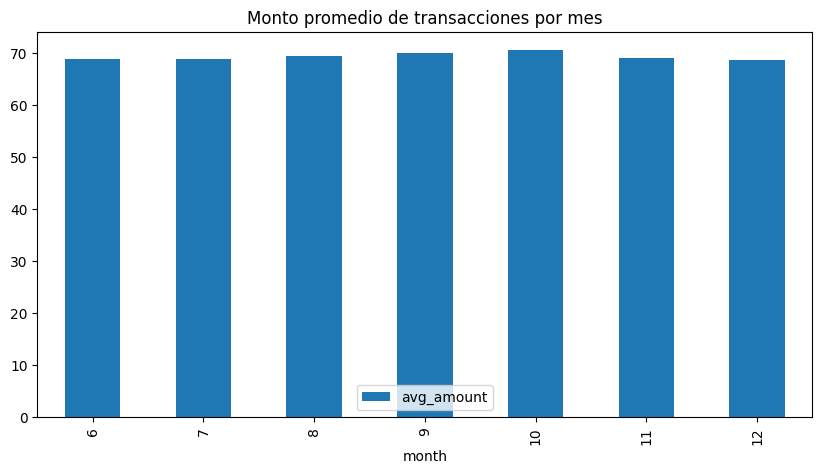

In [31]:
# Grafico 1
df.plot(x='month', y='avg_amount', kind='bar', title='Monto promedio de transacciones por mes', figsize=(10, 5))

### 5.2. ¿Cuál es el monto promedio de transacciones por mes y por género?

### 5.3. ¿Cuál es el monto promedio de transacciones por mes y por género y por ciudad?

### 5.4. ¿Cuál es el porcentaje de transacciones fraudulentas por mes? Mostrar el mes y el porcentaje de transacciones fraudulentas.

### 5.5 ¿Cuál es el género más susceptible a transacciones fraudulentas? Mostrar el género y el porcentaje de transacciones fraudulentas.

### 5.6. ¿Cuál es el porcentaje de transacciones fraudulentas por tienda? Muestre las 10 tiendas con mayor porcentaje de transacciones fraudulentas. Mostrar el nombre de la tienda, la categoría y el porcentaje de transacciones fraudulentas.

### 5.7 ¿Cuál es la categoria de tienda con mayor cantidad de transacciones fraudulentas?. Mostrar el nombre de la categoria y la cantidad de transacciones fraudulentas. Mostrar SOLO la categoria con mayor cantidad de transacciones fraudulentas.

### 5.8 ¿Cuál es el monto promedio de las transacciones fraudulentas por mes? Mostrar el monto promedio y el mes.

### 5.9 ¿Cuál es el cliente que más transacciones fraudulentas realizó? Mostrar el nombre del cliente y la cantidad de transacciones fraudulentas.